In [7]:
%matplotlib inline

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## Astrometric displacement

Let's define the astrometric effect of a GW on a set of stars; this will be given by the displacement `dN`. We will also construct GW polarization basis tensors to construct arbitrary GWs.

In [182]:
def dN(h, n, q):
    """Displacement induced by gravitational wave, Eq. (20) in
    arXiv:1804.00660
    
    Arguments
    ---------
    h : array_like
        gravitational wave strain tensor (3x3)
    n : array_like
        direction to the source.
    q : array_like
        wave propagation direction.
    """
    n = np.array(n)
    q = np.array(q)
    h = np.array(h)
    
    # term1 = (n - q) / (1 - np.dot(q, n))
    norm =  (1 - np.einsum('...i,...i', q, n))
    if n.ndim > 1:
        norm = norm[...,None]
    term1 = (n - q) / norm

    term2 = np.einsum('...jk,...j,...k', h, n, n)
    
    term3 = np.einsum('...ij,...j', h, n)

    missing_dims = term1.ndim - np.ndim(term2)
    for i in range(missing_dims):
        term2 = term2[...,None]
    
    result = 0.5 * (term1 * term2 - term3)
    
    return result

# GW polarization tensors
# WARNING: these expressions assume GW propagates in the z direction, so we must
# have q = (0, 0, 1)
ep = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
ec = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])

# GW waveform
def gw(ap, ac, phi):
    """Gravitational wave strain tensor (circularly polarized wave).
    
    Arguments
    ---------
    ap : float
        amplitude of the plus polarization
    ac : float
        amplitude of the cross polarization
    phi : float
        phase of the wave
    """
    # expand dimensions to broadcast GW tensor
    phi = np.array(phi)
    _ep = ep
    _ec = ec
    for d in phi.shape:
        _ep = _ep[None,...]
        _ec = _ec[None,...]
    if phi.ndim > 0:
        phi = phi[...,None,None]
    
    return ap * _ep * np.cos(phi) + ac * _ec * np.sin(phi)

def dstar(n, phi=0):
    """ Displacement of a star due to a gravitational wave
    propagating in the z direction.
    """
    n = np.atleast_2d(n)  # (n_N, 3)
    phi = np.atleast_1d(phi)  #(n_phi,)
    
    if n.ndim > 2 or n.shape[-1] != 3:
        raise ValueError("n must have shape (3,) or (n, 3)")
    
    if phi.ndim > 1:
        raise ValueError("phi must have shape (n,) or ()")
    
    n = n[None,...]  # (1, n_N, 3)
    phi = phi[...,None]  # (n_phi, 1)
    # gw will add two more dimensions so that phi ends up
    # (n_phi, 1, 1, 1)
    # so that it can be broadasted to the 3x3 GW tensors

    q = np.array([0, 0, 1])*np.ones_like(n)

    return np.squeeze(dN(gw(0.1, 0, phi), n, q))

## Night sky

We will apply the effect of our GW to a field of simulated stars on the night sky.

In [183]:
# create a field of stars to observe
rng = np.random.default_rng(150914)
n_stars = 1000
stars = rng.normal(0, 1, (n_stars, 3))
stars /= np.linalg.norm(stars, axis=1)[:, np.newaxis]

# for visualization, we will only want stars in a single hemisphere
# so force all stars to have positive z component
hemisphericstars = stars.copy()
hemisphericstars[:, 2] = np.abs(hemisphericstars[:, 2])

In [184]:
# np.savetxt('random_stars.csv', stars)

Let's look at the stars we have created as they are distributed over the celestial sphere:

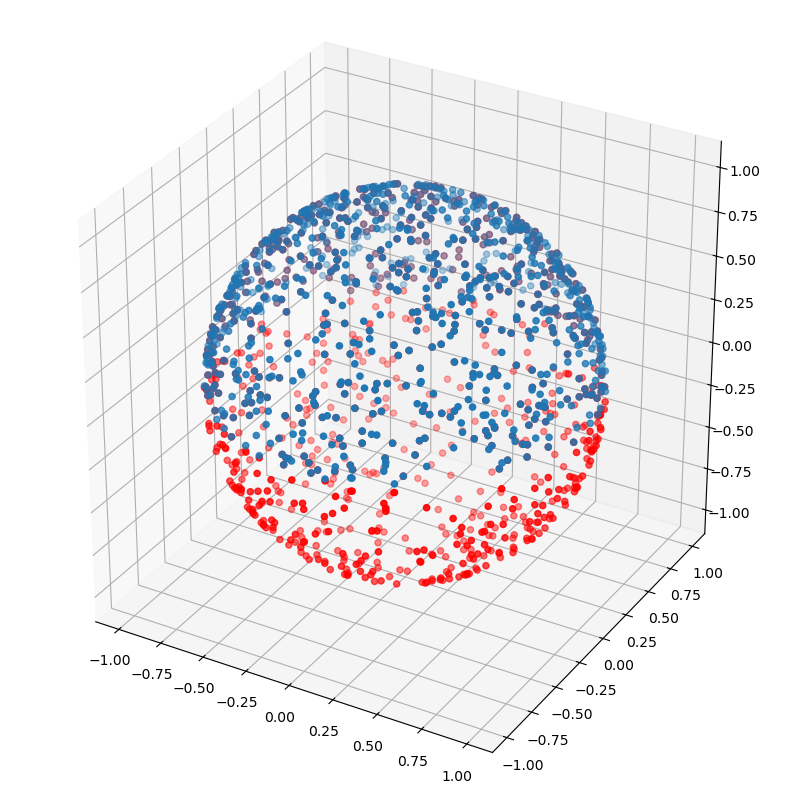

In [185]:
# 3D scatter plot of the stars
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(stars[:, 0], stars[:, 1], stars[:, 2], c='r')
ax.scatter(hemisphericstars[:, 0], hemisphericstars[:, 1], hemisphericstars[:, 2])
# make square aspect ratio
ax.set_box_aspect([1,1,1])

Since we will imagine staring up at the sky, we will project our stars onto the field of view (a plane):

In [186]:
# finally, we will want to look at the projection of the hemisphere
flatstars = hemisphericstars[:, :2]

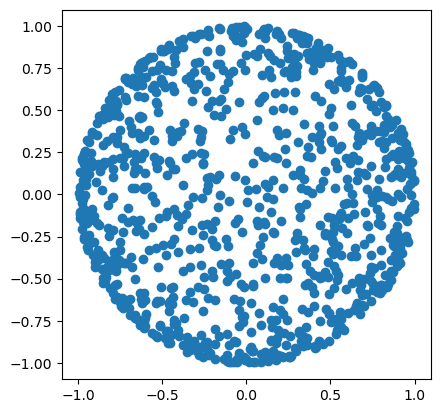

In [187]:
fig, ax = plt.subplots()
ax.scatter(flatstars[:, 0], flatstars[:, 1])
ax.set_aspect('equal')

## Displacement

Now we apply the GW to our set of simulated stars.

In [212]:
# get set of displacements for all stars
d = dstar(hemisphericstars, phi=phi)

# update the star locations
newstars = hemisphericstars + d
newstars /= np.linalg.norm(newstars, axis=-1)[..., np.newaxis]

newflatstars = newstars[...,:2]
newstars.shape

(100, 1000, 3)

array([0.17358696, 0.35260605, 0.91953061])

In [220]:
newstars[0,1,:]

array([0.17358696, 0.35260605, 0.91953061])

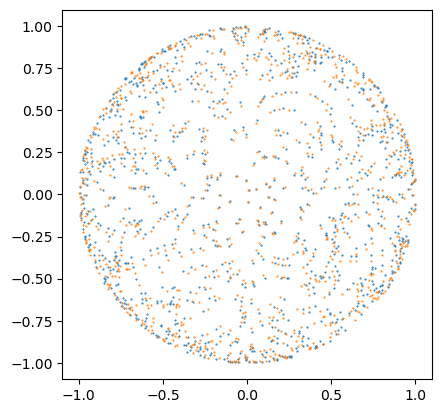

In [202]:
fig, ax = plt.subplots()
ax.scatter(flatstars[:, 0], flatstars[:, 1], marker='.', s=1)
ax.scatter(newflatstars[:, 0], newflatstars[:, 1], marker='.', s=1)
ax.set_aspect('equal')

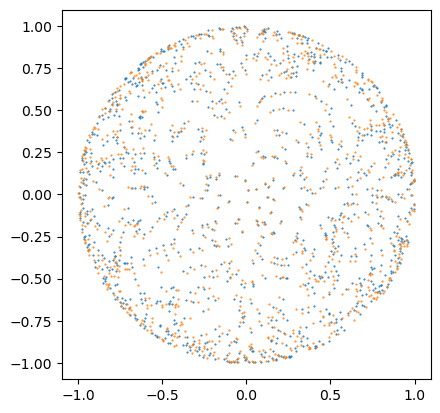

In [208]:
# animate the above plot to make a GIF
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.scatter(flatstars[:, 0], flatstars[:, 1], marker='.', s=1)
sc = ax.scatter([], [], marker='.', s=1)
# set equal aspect ratio for ax
ax.set_aspect('equal')


def animate(phi):
    d = dstar(hemisphericstars, phi)
    newstars = hemisphericstars + d
    
    newstars /= np.linalg.norm(newstars, axis=-1)[..., np.newaxis]
    newflatstars = newstars[...,:2]
    
    sc.set_offsets(newflatstars)
    return sc,

ani = FuncAnimation(fig, animate, frames=np.linspace(0, 2*np.pi, 100), blit=True);

In [199]:
HTML(ani.to_jshtml())